In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray
import time
import matplotlib.patches as patches
import glob

import matplotlib.colors as mcolors

from netCDF4 import Dataset
from scipy import stats

from matplotlib.animation import FuncAnimation

import geopandas as gpd
import geocube
from geocube.api.core import make_geocube
## estimate of pressure levels from the hybrid coordinate:
## lev0=975, 5=925, 8=850, 12=700, 17=500,  19=400, 21=300, 24=200, 29=100

ERROR 1: PROJ: proj_create_from_database: Open of /ocean/projects/atm200007p/xjliu/miniconda3/envs/geocube_env/share/proj failed


### First, load the lats, lons, and levs used for plotting later.

In [2]:
### Plot the height vs. time sections of potential temperature
import xarray
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'Amazon961x801_201509_201602/wrfinput_d01'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1:
    lats=ds1['XLAT'][0,:,0]
    lons=ds1['XLONG'][0,0,:]
    lu1=ds1['LU_INDEX'][0,:,:]

### Check whether LUindex is changed correctly

<xarray.DataArray 'LU_INDEX' (west_east: 100)>
array([17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 16., 16., 16.,
       16., 16., 16., 16., 16.,  7.,  7.,  7.,  7., 10.,  7., 10.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7., 10., 10.,  7.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        7.,  7., 10.,  7., 10., 10., 10., 10.,  9., 10., 10., 10., 10., 10.,
        2.,  2.], dtype=float32)
Coordinates:
    XLAT     (west_east) float32 ...
    XLONG    (west_east) float32 ...
Dimensions without coordinates: west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  LAND USE CATEGORY
    units:        
    stagger:      
    coordinates:  XLONG XLAT XTIME


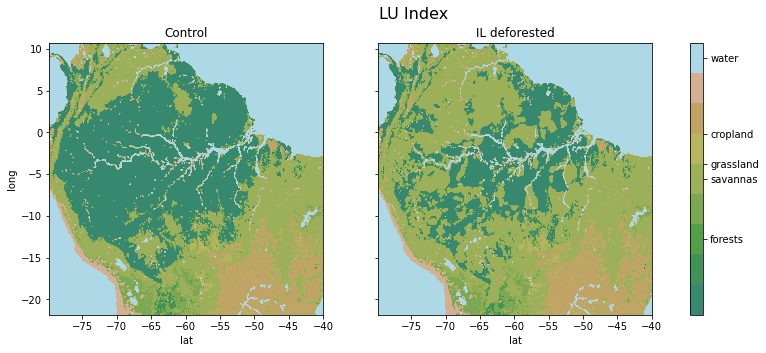

In [3]:
file0 = path+'Amazon961x801_200809_200902/wrfinput_d01'
with xarray.open_dataset(file0,decode_times=False,
                         mask_and_scale='True') as ds0:
    lu0=ds0['LU_INDEX'][0,:,:]

file1 = path+'Amazon961x801_200809_200902_ILgrassland/wrfinput_d01'
with xarray.open_dataset(file1,decode_times=False,
                         mask_and_scale='True') as ds1:
    lu1=ds1['LU_INDEX'][0,:,:]

### generate a new cmap
cmap = plt.get_cmap('gist_earth')
colors = cmap(np.linspace(0.3, 0.89, 100))
new_cmap = mcolors.LinearSegmentedColormap.from_list('test',colors)
new_cmap.set_over('lightblue')
############

fig,axes = plt.subplots(1,2,figsize=(13.5,5),sharex=True,sharey=True)
axes = axes.ravel()  
im=axes[0].contourf(lons,lats,lu0,cmap=new_cmap,vmax=16)  # ctrl luindex
axes[1].contourf(lons,lats,lu1,cmap=new_cmap,vmax=16)     # ILdeforeste luindex
axes[0].set_title('Control')
axes[1].set_title('IL deforested')
axes[0].set_xlabel('lat')
axes[1].set_xlabel('lat')
axes[0].set_ylabel('long')
plt.suptitle('LU Index',fontsize=16)
cbar = fig.colorbar(im,ax=axes, ticks = [5,9,10,12,17])
cbar.ax.set_yticklabels(['forests', 'savannas','grassland','cropland','water'])  # vertically oriented colorbar

print(lu1[300,:100])

# Precipitation plot

## 1. 6-month accumulated precipitation

### Mean precipitation

ok
ok


Text(0, 0.5, 'longitude')

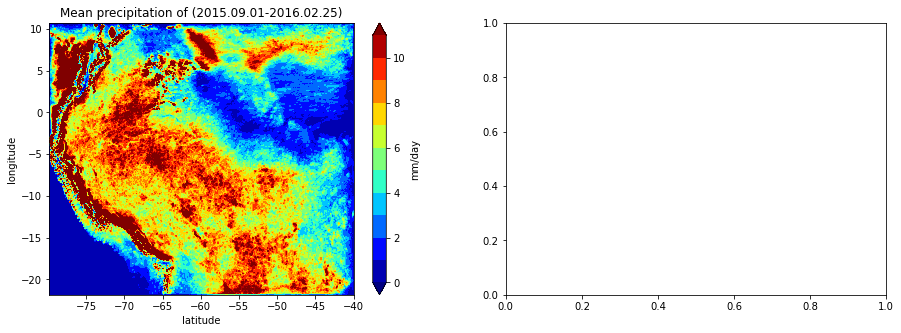

In [22]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
with xarray.open_dataset(path+'Amazon961x801_201509_201602/energyflux_d01_2016-02-28_00:00:00',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')

with xarray.open_dataset(path+'Amazon961x801_201509_201602_ILgrassland/energyflux_d01_2016-02-28_00:00:00',decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')
    
fig, axs = plt.subplots(1,2,figsize=(15,5))
im=axs[0].contourf(lons,lats,ds0['RAINNC'][-1,:,:]/178,cmap='jet',
               levels=np.arange(0,12,1),extend='both')
fig.colorbar(im,ax=axs[0],label='mm/day')
axs[0].set_title('Mean precipitation of (2015.09.01-2016.02.25)')
#axs[0].contour(lons,lats,lu1-lu0,levels=[1])
#axs[0].contourf(lons,lats,IL_sel,hatches='+',alpha=0.1)

axs[0].set_xlabel('latitude')
axs[0].set_ylabel('longitude')


#### load in the Indigenous lands information for use in plotting

In [4]:
directory = '/ocean/projects/ees210014p/xjliu/DATA/landuse/'
shapefile = 'Raisg/Tis_2020/Tis_TerritoriosIndigenas.shp'  
IL1 = gpd.read_file(directory+shapefile) # read into a GeoDataFrame
IL_big = IL1[IL1.area_sig_h>1.6e5]  # select only the big domain
## rasterize data
IL_big['value']=1
IL1['value']=1
out_grid = make_geocube(IL_big,resolution=(0.04,-0.04),measurements=['value'],fill=-9999)
da_grib = xarray.where(out_grid.value<-1999.0, np.nan, out_grid.value)

with xarray.open_dataset(path+'Amazon961x801_200809_200902/wrfinput_d01_20080901',decode_times=False) as ds:
    print('ok')
lats = ds['XLAT'][0,:,:]
lons = ds['XLONG'][0,:,:]

IL_sel = da_grib.sel(y=lats[:,0],x=lons[0,:],method='nearest')
IL_sel.shape

/ocean/projects/atm200007p/xjliu/miniconda3/envs/geocube_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


ok


(800, 960)

In [34]:
files_control=['Amazon961x801_201509_201602/energyflux_d01_2016-02-28_00:00:00',
              'Amazon961x801_200509_200602/energyflux_d01_2006-02-28_00:00:00',
              'Amazon961x801_201009_201102/energyflux_d01_2011-02-05_00:00:00',
              'Amazon961x801_200809_200902/energyflux_d01_2009-02-28_00:00:00']
files_grassland=['Amazon961x801_201509_201602_ILgrassland/energyflux_d01_2016-02-28_00:00:00',
              'Amazon961x801_200509_200602_ILgrassland/energyflux_d01_2006-02-28_00:00:00',
              'Amazon961x801_201009_201102_ILgrassland/energyflux_d01_2011-02-05_00:00:00',
              'Amazon961x801_200809_200902_ILgrassland/energyflux_d01_2009-02-28_00:00:00']
ii=2
with xarray.open_dataset(path+files_control[ii],decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')

with xarray.open_dataset(path+files_grassland[ii],decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')
    
### calculate area-averaged precipitation
dif_prec = ds1['RAINNC'][-1,:,:]-ds0['RAINNC'][-1,:,:]
dif_prec.shape
dif_prec_IL = dif_prec.where(dif_lu>0,np.nan) # Inside IL
dif_prec_out = dif_prec.where(dif_lu==0,np.nan) # outside IL
dif_prec_IL_areaave = dif_prec_IL.mean(('south_north','west_east'))
dif_prec_out_areaave = dif_prec_out.mean(('south_north','west_east'))

print(dif_prec_out_areaave/158)
print(dif_prec_IL_areaave/158)

ok
ok
<xarray.DataArray 'RAINNC' ()>
array(-0.17962648)
<xarray.DataArray 'RAINNC' ()>
array(0.42604166)


In [35]:
prec_IL=[0.42,0.56,0.57,0.43]
prec_out=[-0.16,-0.14,-0.15,-0.18]

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
im=axs[0].contourf(lons,lats,ds0['RAINNC'][-1,:,:],cmap='YlGn',
               levels=np.arange(0,2001,200),extend='both')
fig.colorbar(im,ax=axs[0],label='mm/day')
axs[0].set_title('Mean precipitation of (2015.09.01-2016.02.25)')
#axs[0].contour(lons,lats,lu1-lu0,levels=[1])
axs[0].contourf(lons,lats,IL_sel,hatches='+',alpha=0.1)

axs[0].set_xlabel('latitude')
axs[0].set_ylabel('longitude')

im=axs[1].pcolormesh(lons,lats,ds1['RAINNC'][-1,:,:]-ds0['RAINNC'][-1,:,:],cmap='PiYG',
              vmin=-1000,vmax=1000 )
fig.colorbar(im,ax=axs[1],label='mm')
axs[1].set_title('Change in accumulated precipitation')
#axs[1].contour(lons,lats,lu1-lu0,levels=[1])
axs[1].contourf(lons,lats,IL_sel,hatches='o',alpha=0.0)
axs[1].set_xlabel('latitude')
#axs[1].set_ylabel('longitude')

## Change in monthly mean precipitation

<ipython-input-18-ebd1a4cdabe7>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[3*ii].pcolormesh(lons,lats,prec0_mon[ii,:,:],
<ipython-input-18-ebd1a4cdabe7>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[3*ii+1].pcolormesh(lons,lats,prec1_mon[ii,:,:],
<ipython-input-18-ebd1a4cdabe7>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the qua

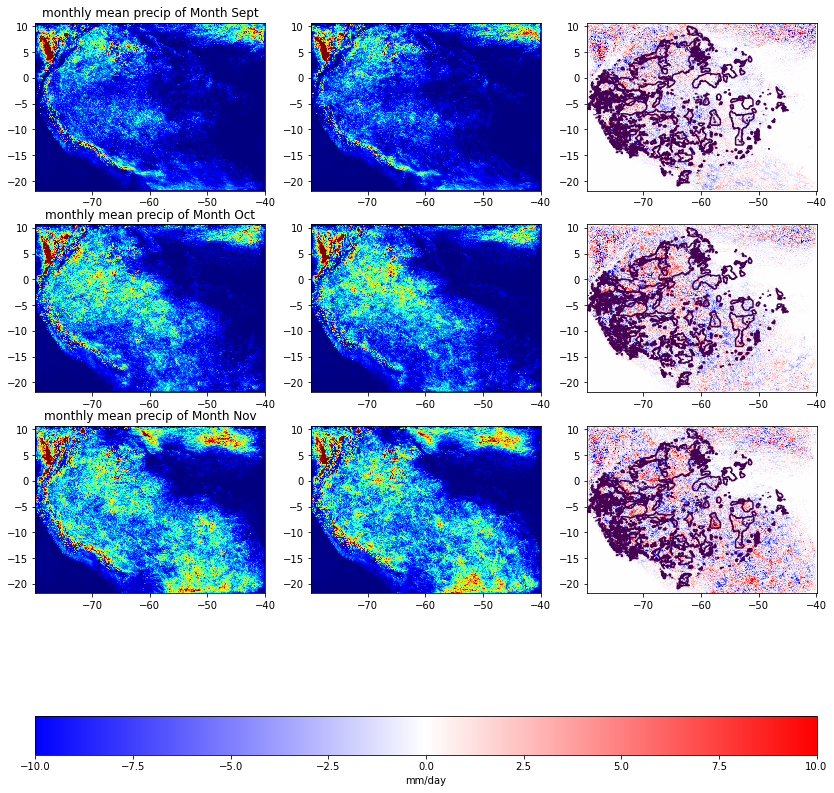

In [ ]:
fig, axes = plt.subplots(3,3,figsize=(14,15))
axes = axes.ravel()
months = ['Sept','Oct','Nov','Dec','Jan','Feb']
for ii in range(3):
    im = axes[3*ii].pcolormesh(lons,lats,prec0_mon[ii,:,:],
                       vmin=0,vmax=20,cmap='jet')
    im = axes[3*ii+1].pcolormesh(lons,lats,prec1_mon[ii,:,:],
                       vmin=0,vmax=20,cmap='jet')
    im = axes[3*ii+2].pcolormesh(lons,lats,prec1_mon[ii,:,:] - prec0_mon[ii,:,:],
                       vmin=-10,vmax=10,cmap='bwr')
    axes[3*ii+2].contour(lons,lats,lu1-lu0,levels=[1])
    axes[3*ii].set_title('monthly mean precip of Month '+months[ii])

fig.colorbar(im, ax=axes,label='mm/day',orientation='horizontal')

## Calculation of MCWD
### accumulation of precip - ET (set it to be constant here 3.3 mm/day) greater than 0

In [10]:
cwd0 = np.zeros(prec0_day.shape)
cwd1 = np.zeros(prec0_day.shape)

#prec0_day[]
for ii in range(1,180):
    cwd0[ii,:,:] = cwd0[ii-1,:,:] + prec0_day[ii,:,:] - 3
    cwd0[ii,:,:]= np.where(cwd0[ii,:,:]>0,0,cwd0[ii,:,:])   
    
    cwd1[ii,:,:] = cwd1[ii-1,:,:] + prec1_day[ii,:,:] - 3
    cwd1[ii,:,:]= np.where(cwd1[ii,:,:]>0,0,cwd1[ii,:,:])   

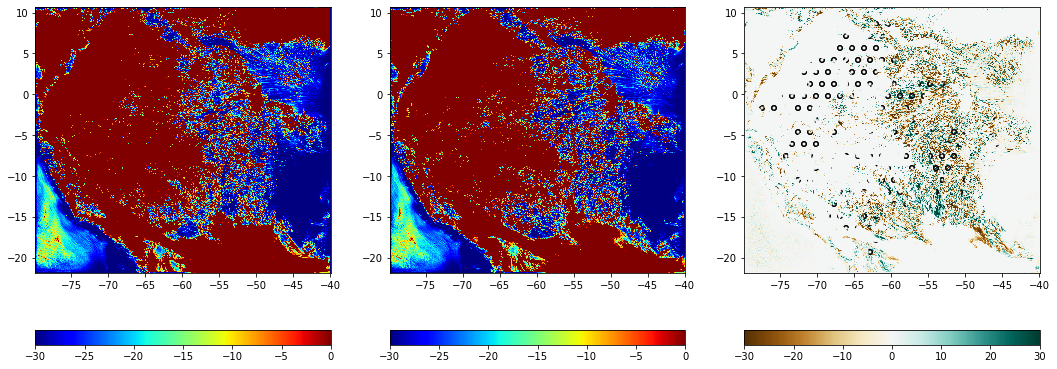

In [16]:
fig, axes = plt.subplots(1,3,figsize=(18,7))
axes = axes.ravel()

TIME=10
im0 = axes[0].pcolormesh(lons,lats,cwd0[TIME,:,:],cmap='jet')
im1 = axes[1].pcolormesh(lons,lats,cwd1[TIME,:,:],cmap='jet')
im2=axes[2].pcolormesh(lons,lats,cwd1[TIME,:,:]-cwd0[TIME,:,:],cmap='BrBG')
axes[2].contourf(lons,lats,IL_sel,hatches='o',alpha=0.0)
fig.colorbar(im0,ax=axes[0],orientation='horizontal')
fig.colorbar(im1,ax=axes[1],orientation='horizontal')
fig.colorbar(im2,ax=axes[2],orientation='horizontal')

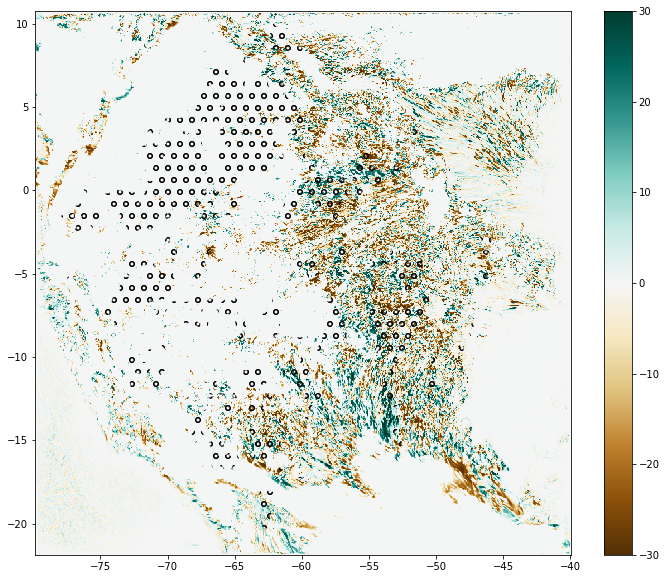

In [21]:
plt.figure(figsize=(12,10))
plt.pcolormesh(lons,lats,cwd1[TIME,:,:]-cwd0[TIME,:,:],cmap='BrBG')
plt.colorbar()
plt.contourf(lons,lats,IL_sel,hatches='o',alpha=0.0)
